In [268]:
"""
# Notebook demonstrating some concepts from 1.2 - 1.5 of Theoretical Neuroscience
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)
# sns.set(rc={'figure.figsize':(11.7,2.27)})

## Firing Rates

Suppose we had a set of neural data, spikes recorded from two neurons over four trials. What are the different kinds of firing rate?

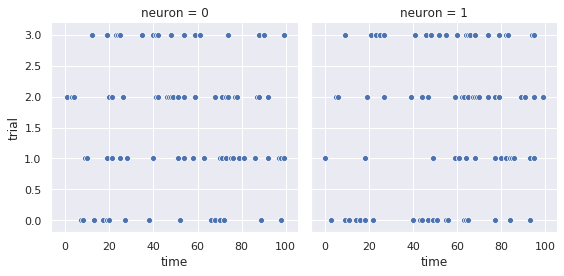

In [271]:
np.random.seed(0)
# Simulate spikes as random occurrences - we aren't concerned with how they're actually generated right now.
from scipy.stats import bernoulli

n_trials = 4
n_neurons = 2
trial_length = 100

p = 0.2
data = bernoulli.rvs(p, size=(n_trials, n_neurons, trial_length))
df = pd.DataFrame(columns=["time", "neuron", "trial"])

# Show the neuron activity
for i in range(n_neurons):
    for j in range(n_trials):
        index = i * (n_trials + 1) + j
        spike_times = np.nonzero(data[j, i])[0]
        trial_info = pd.DataFrame.from_dict({"time": spike_times, "neuron": i, "trial": j})
        df = df.append(trial_info, ignore_index=True)

df.head()

plot = sns.relplot(x="time", y="trial", col="neuron", data=df, kind="scatter", height=4)

plot.set(xticks=np.arange(0, trial_length + 1, 20))


Note the above is dense representation of several neural response functions, $\rho(t)$, as written in the text. Let's calculate some firing rates. Since we have discrete data, we need to set a bin size.

Trial 0, neuron 0 => r: 0.15
<r>: 19.75


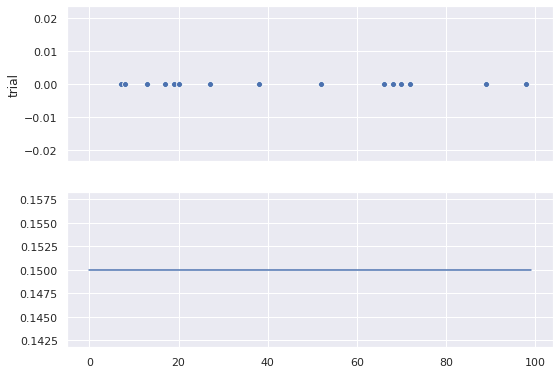

In [279]:
# Spike-count rate - for a given neuron and trial, spikes over trial time
trial = 0
neuron = 0

trial_data = df[df['neuron'] == neuron][df['trial'] == trial]

spike_count = len(trial_data)
rate = spike_count / trial_length
print(f"Trial {trial}, neuron {neuron} => r: {rate}")

_, (ax1, ax2) = plt.subplots(2, sharex=True) 
sns.scatterplot(x="time", y="trial", data=trial_data, ax=ax1)
sns.lineplot(x=np.arange(trial_length), y=rate, ax=ax2)

# Or we can average over trials (average firing rate)
counts = np.sum(data[:, neuron], axis=1)
trial_averaged_rate = np.mean(counts)
print(f"<r>: {trial_averaged_rate}") # Note, this is pretty much the probability we generated our data at. 

The main rate used is known just as "firing rate", $r(t)$. This combines trial averaging with overlapping bins, where in theory bin size approaches zero. In the limit, $r(t)\delta t$ describes the probability of a spike at around time $t$.

Disclaimer: Trial-averaging assumes that the behavivor of the neuron is constant during the time intervals you're binning across, across trials. This is typically generally true, depending on the neuron domain.

Text(0, 0.5, 'r(t)')

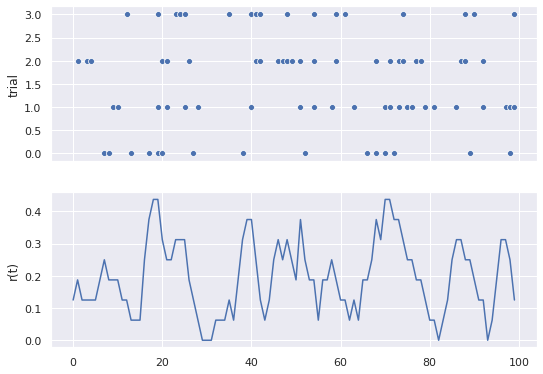

In [280]:
# For finer resolution, we consider spikes in time bins instead of entire trials.

neuron = 0
bin_size = 4

trial_averaged_data = data[:,neuron].mean(axis=0) # <\rho(t)>
# Slide the bin across time, and record number of spikes in each bin
# We use the source data for calculations as the dataframe is more for presentation

# Pad the data with zeros so we can sum more easily - note this means our last few timesteps will have off firing rates
padded_data = np.concatenate((trial_averaged_data, np.zeros(bin_size-1)))
binned_data = sum([padded_data[i:i + trial_length] for i in range(bin_size)])
firing_rate = binned_data/bin_size

_, (ax1, ax2) = plt.subplots(2, sharex=True) 
sns.scatterplot(x="time", y="trial", data=df[df['neuron'] == neuron], ax=ax1)
sns.lineplot(x=np.arange(trial_length), y=firing_rate, ax=ax2)
ax2.set_ylabel("r(t)")

## A Poisson Process

Faithfully describing the entire probability space of a spike train of length $T$ is intractable.
A poisson process is a simple, effective (and thus widely used) model, which allows us to describe probabilities for sequences with just the firing rate. It's a point process, which assumes events do not affect each other, so a spike sequence is characterized by spike count.
See: https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459 for uses in other places!

A poisson process is described by a single statistic $\lambda$: the expected number of events in an interval of time (and for us, the event is a spike!). So if we have a firing rate $r$ for a neuron, and we work in time intervals of $T$, we have $\lambda = rT$. The model parameterized by $\lambda$ is then a probability distribution over $k$ firings. 

Let's explore the Poisson model.

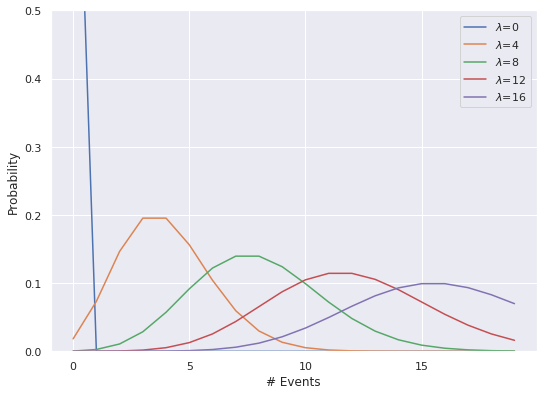

In [218]:
#%% Poisson rates
# poisson pmf plots
sns.set(rc={'figure.figsize':(8.7,6.27)})
from scipy.stats import poisson
def get_pmf(n, x):
    # evaluate pmf of poisson w/ lambda = n @ x
    return poisson(n).pmf(x) 

x = np.arange(0, 20, 1)
plt.ylim(0, 0.5)
plt.ylabel("Probability")
plt.xlabel("# Events")
plt.xticks(np.arange(0, 20, 5))

for n in np.arange(0, 20, 4):
    plt.plot(x, get_pmf(n, x), label= f"$\lambda$={n}")
plt.legend()

As we can see, the peak probability occurs at $\lambda$ (it is the expected value of the smooth function, after all). The text makes a point that at higher $\lambda$, the process starts resembling Gaussian probabilities around $\lambda$. Below we show a poisson process $\lambda=10$ resembles a normal distribution with mean and variance of 10.

Why that variance? Turns out it's the variance of Poisson-modeled spike count as well!

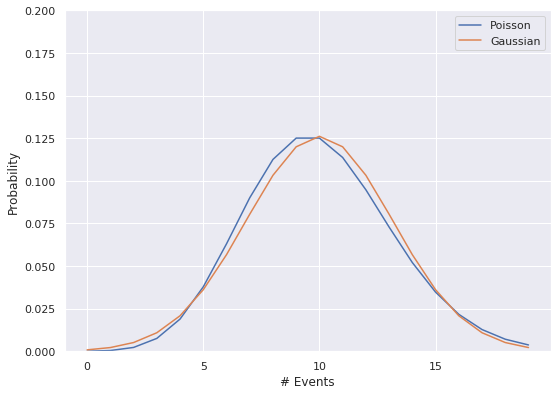

In [282]:
from scipy.stats import norm
import math 

x = np.arange(0, 20, 1)
plt.ylim(0, 0.2)
plt.ylabel("Probability")
plt.xlabel("# Events")
plt.xticks(np.arange(0, 25, 5))

n = 10
var = math.sqrt(n)

plt.plot(x, get_pmf(n, x), label="Poisson")
plt.plot(x, norm.pdf(x, n, var), label="Gaussian")

plt.legend()

## Homogeneous vs Inhomogeneous Poisson Process

Our neurons don't fire at a constant rate. We can still use a Poisson process, but we should move away from the constant $\lambda$ constraint. This makes the pdf plot much less well behaved, and we also can't visualize it as easily, since our probability distribution depends on the time of each spike. The pdf is described as
$$
p\left[t_{1}, t_{2}, \ldots, t_{n}\right]=\exp \left(-\int_{0}^{T} d t r(t)\right) \prod_{i=1}^{n} r\left(t_{i}\right)
$$

However, we can understand inhomogeneous poisson processes by simulating them.

## Poisson Spike Generator

Now that we have a better model for neural firing, let's simulate some more faithful neural data. We can move from randomly assigning spike locations to randomly choosing firing rates, which will generate more realistic firing patterns. We replicate the text, with a neuron sensitive to orientation.


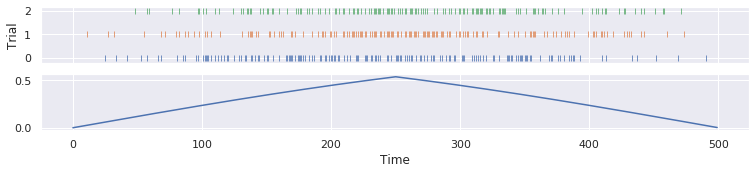

In [296]:
np.random.seed(0)
num_trials = 3
trial_length = 500
time = np.arange(trial_length)
orientation = time / trial_length * 2 * np.pi # 0 - 2pi
firing_rate = np.tanh((1 - np.abs((np.pi - orientation)) / np.pi) * 0.6)


spikes = np.zeros((num_trials, trial_length))
for i in range(trial_length): # delta t is 1 second
    threshold = firing_rate[i]
    spikes[:,i] = np.random.random(num_trials) < threshold

sns.set(rc={'figure.figsize':(12.7,2.27)})
_, (ax1, ax2) = plt.subplots(2, sharex=True) 
ax1.set_ylabel("Trial")
ax1.set_yticks(np.arange(3))
ax2.set_xlabel("Time")
for i in range(num_trials):
    sns.scatterplot(x=spikes[i].nonzero()[0], y=i, marker="|", ax=ax1)    
sns.lineplot(time, firing_rate, ax=ax2)

# spikes = 
# # Let's shift the phases of the neurons
# offset_times = [time + i for i in range(n)]
# time_array = np.stack(offset_times, axis=0)
# trials = np.sin(time_array) + np.randosm.random((n_trials, n_neurons, trial_length)) + 1

## Refractory Periods
A simple way to make our model more realistic is to incorporate refractory periods, i.e. inhibit firing rate after a spike is triggered. This will make our interspike interval distribution smoother less peaky. We do so with an exponential of up to 3 timesteps.

Text(0.5, 0, 'Timesteps elapsed')

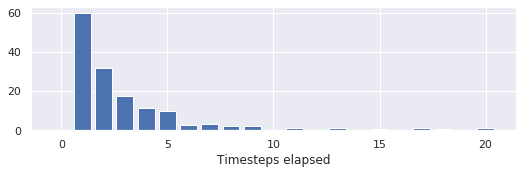

In [369]:
sns.set(rc={'figure.figsize':(8.7,2.27)})

# Plot simple interspike distribution
np.random.seed(0)
num_trials = 3
trial_length = 500
time = np.arange(trial_length)
orientation = time / trial_length * 2 * np.pi # 0 - 2pi
firing_rate = np.tanh((1 - np.abs((np.pi - orientation)) / np.pi) * 0.6)


spikes = np.zeros((num_trials, trial_length))
for i in range(trial_length): # delta t is 1
    threshold = firing_rate[i]
    spikes[:,i] = np.random.random(num_trials) < threshold

max_distance = 20
interspike_intervals = np.zeros((num_trials, max_distance + 1))
for n in range(num_trials):
    trial_data = spikes[n]
    spike_times = trial_data.nonzero()[0]
    for i in range(len(spike_times) - 1):
        dist = min(spike_times[i+1] - spike_times[i], max_distance)
        interspike_intervals[n][dist] += 1
plt.bar(np.arange(max_distance + 1), interspike_intervals.mean(axis=0))
plt.xlabel("Timesteps elapsed")

Text(0.5, 0, 'Timesteps elapsed')

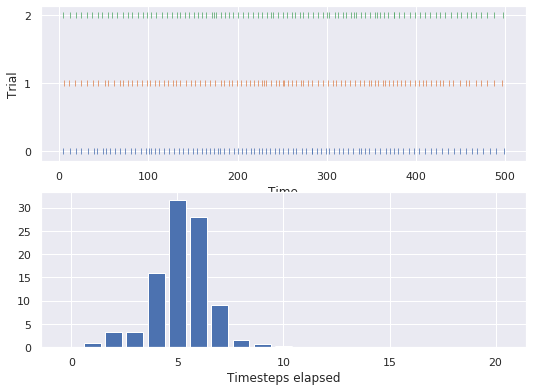

In [371]:
sns.set(rc={'figure.figsize':(8.7,6.27)})

# Plot simple interspike distribution
np.random.seed(0)
num_trials = 3
trial_length = 500
time = np.arange(trial_length)
orientation = time / trial_length * 2 * np.pi # 0 - 2pi
firing_rate = np.tanh((1 - np.abs((np.pi - orientation)) / np.pi))

spikes = np.zeros((num_trials, trial_length))
recovery_cap = 5
recovery = np.ones(num_trials) * recovery_cap # time since last fired
for i in range(trial_length): # delta t is 1 second
    threshold = firing_rate[i]
    refractory_multiplier = np.exp(recovery - recovery_cap)
    spikes[:,i] = np.random.random(num_trials) < threshold * refractory_multiplier
    recovery = (1 - spikes[:, i]) * recovery # 1 if fired, 0 if didn't
    recovery += 1

_, (ax1, ax2) = plt.subplots(2) 
ax1.set_ylabel("Trial")
ax1.set_yticks(np.arange(3))
ax1.set_xlabel("Time")
ax2.set_xlabel("Timesteps elapsed")
for i in range(num_trials):
    sns.scatterplot(x=spikes[i].nonzero()[0], y=i, marker="|", ax=ax1)    

max_distance = 20
interspike_intervals = np.zeros((num_trials, max_distance + 1))
for n in range(num_trials):
    trial_data = spikes[n]
    spike_times = trial_data.nonzero()[0]
    for i in range(len(spike_times) - 1):
        dist = min(spike_times[i+1] - spike_times[i], max_distance)
        interspike_intervals[n][dist] += 1
ax2.bar(np.arange(max_distance + 1), interspike_intervals.mean(axis=0))
ax2.set_xlabel("Timesteps elapsed")

## Autocorrelation and Cross Correlation

Correlation functions are a simple method to show linear relationships (correlations) between two signals. Autocorrelation measures correlation between a spike train and itself, offset by some time, and cross-correlation can illuminate connections between two neurons' trains. Correlations can reveal many patterns, we demonstrate an oscillatory one below.

Text(0.5, 0, 'Timesteps elapsed')

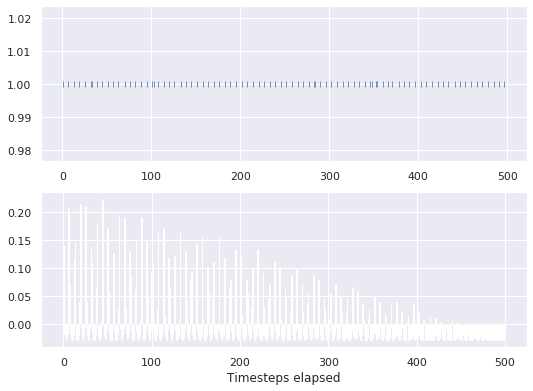

In [397]:
# mean centered
np.random.seed(0)
num_trials = 3
trial_length = 500
time = np.arange(trial_length)
firing_rate = np.sin(time)

spikes = np.zeros((num_trials, trial_length))
recovery_cap = 5
recovery = np.ones(num_trials) * recovery_cap # time since last fired
for i in range(trial_length): # delta t is 1 second
    threshold = firing_rate[i]
    refractory_multiplier = np.exp(recovery - recovery_cap)
    spikes[:,i] = np.random.random(num_trials) < threshold * refractory_multiplier
    recovery = (1 - spikes[:, i]) * recovery # 1 if fired, 0 if didn't
    recovery += 1

# spikes have data again

trial = spikes[0]
n_spikes = sum(trial)
mean_centering = n_spikes ** 2 / trial_length
tau = 0 # Autocorrelation
trial_1 = spikes[0][:-1*tau + trial_length]
trial_2 = spikes[0][tau:]
spike_1 = trial_1.nonzero()[0]
spike_2 = trial_2.nonzero()[0]

# bin size of 1
interspike_intervals = np.zeros(trial_length) - mean_centering
trial_data = spikes[n]

for i in range(len(spike_1)):
    for j in range(len(spike_2)):
        interspike_intervals[abs(spike_2[j] - spike_1[i])] += 1

interspike_intervals /= trial_length
_, (ax1, ax2) = plt.subplots(2) 
sns.scatterplot(x=trial.nonzero()[0], y=1, marker="|", ax=ax1)
ax2.bar(time, interspike_intervals, color="red")
ax2.set_xlabel("Timesteps elapsed")

## Poisson in Practice

In reality, neurons are a lot more precise than a simple point process. Noise and stochasticity is largely a result of limited recording ability. However, the Poisson process is flexible and does end up sharing many statistical properties of observed data. Thus, it's a cost effective model for neural data.
